In [1]:
## import libraries
import os, sys
import yaml
import re
import xarray as xr
import pandas as pd
import numpy as np
from datetime import timedelta
%matplotlib inline
from datetime import timedelta

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import textwrap
import cmocean.cm as cmo

# import personal modules
sys.path.append('../modules')
import custom_cmaps as ccmap
from plotter import draw_basemap
import ar_funcs
# dask.config.set(**{'array.slicing.split_large_chunks': True})

ERROR 1: PROJ: proj_create_from_database: Open of /home/dnash/miniconda3/envs/SEAK-impacts/share/proj failed


In [2]:
path_to_data = '/expanse/nfs/cw3e/cwp140/'      # project data -- read only
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
## load the preprocessed mclimate comparison to AR dates at 72 hour lead
fname_pattern = path_to_data + 'preprocessed/mclimate_AR_dates/mclimate_ivt_*_F72.nc'
ds = xr.open_mfdataset(fname_pattern, engine='netcdf4', combine='nested', concat_dim="valid_time")
ds

<xarray.Dataset>
Dimensions:       (valid_time: 2463, lat: 241, lon: 279)
Coordinates:
  * lat           (lat) float64 70.0 69.75 69.5 69.25 ... 10.75 10.5 10.25 10.0
  * lon           (lon) float64 -179.5 -179.2 -179.0 ... -110.5 -110.2 -110.0
    init_time     (valid_time) datetime64[ns] 2000-01-03 ... 2019-08-23
  * valid_time    (valid_time) datetime64[ns] 2000-01-06 ... 2019-08-26
Data variables:
    ivt_mclimate  (valid_time, lat, lon) float64 dask.array<chunksize=(1, 241, 279), meta=np.ndarray>

In [4]:
## split by community and impact dates
## bounding boxes for composite analysis
bboxes = [[-140.5, -137., 58.25, 60.75], # Yakutat (Northern Coastal)
          [-136.5, -134.75, 56.0, 58.25], # Sitka / Hoonah (Central Coastal)
          [-137.0, -134.75, 58.25, 60.5], # Skagway/Klukwan/Haines (Northern Inner Channel)
          [-134.75, -132.5, 56.75, 58.5], # Juneau/Hoonah/Gustavas (Central Inner Channel)
          [-134.25, -132.5, 54.25, 56.75], # Craig (Southern Coastal)
          [-132.5, -131.25, 54.5, 56.75]] # Kasaan (Southern Inner Channel)

zone_lst = ['northern_coastal', 'central_coastal', 'northern_inner_channel', 'central_inner_channel', 'southern_coastal', 'southern_inner_channel']

impact_level_lst = ['low', 'medium', 'high']
zone = 'southern_inner_channel'
dates_lst = []
for i, impact_level in enumerate(impact_level_lst):
    fname = '../out/{0}_{1}_impact_precip_dates.csv'.format(zone, impact_level)
    df = pd.read_csv(fname)
    ts = pd.to_datetime(df.date.values)
    dates_lst.append(ts)

print(len(dates_lst[0]), len(dates_lst[1]), len(dates_lst[2]))

1442 675 221


In [5]:
data_lst = []
for i, dt_vals in enumerate(dates_lst):
    tmp = ds.sel(valid_time=dt_vals) # subset to high/medium/low impact dates
    # tmp = tmp.isel(valid_time=100)
    tmp = tmp.mean('valid_time') # average the composite
    data_lst.append(tmp)

In [6]:
np.nanmax(data_lst[2].ivt_mclimate.values)

0.8885

In [7]:
# Set up projection
mapcrs = ccrs.Mercator()
# mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
lats = data_lst[0].lat.values
lons = data_lst[0].lon.values
dx = np.arange(lons.min().round(),lons.max().round()+10,10)
dy = np.arange(lats.min().round(),lats.max().round()+5,5)

ext = [-170., -120., 40., 65.]

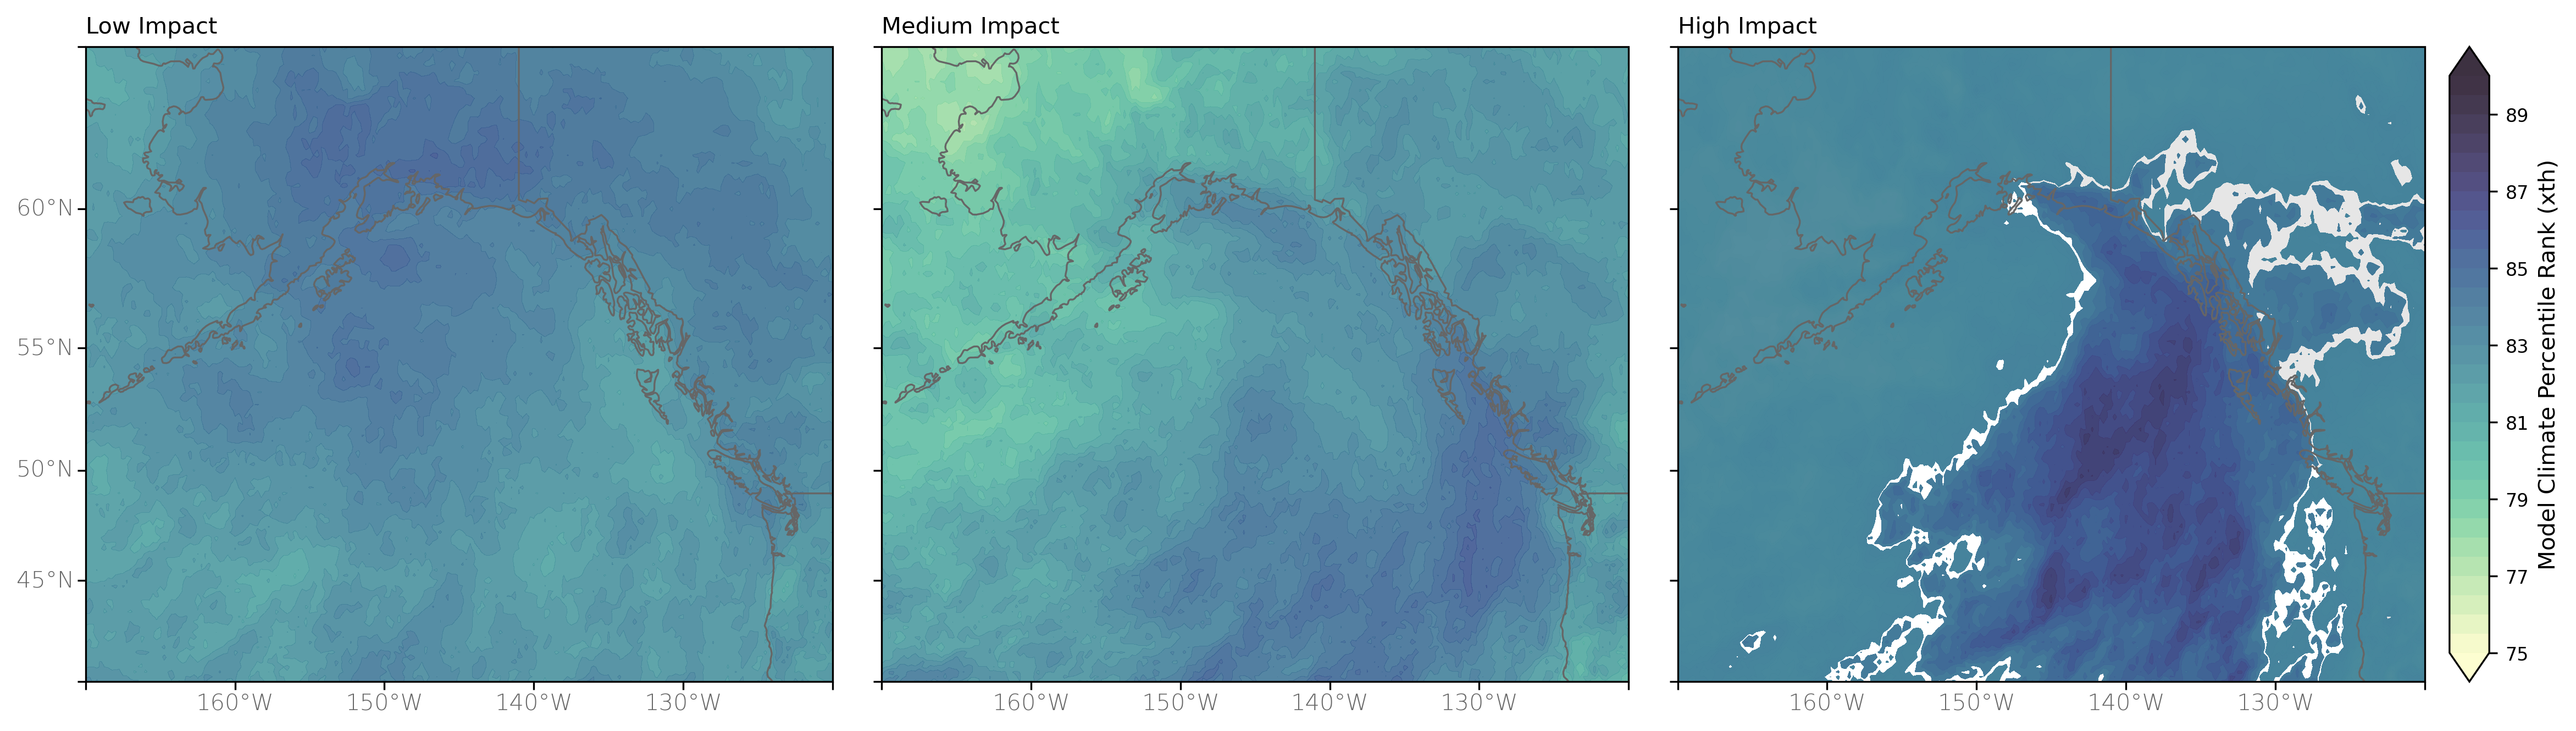

In [8]:
# Create figure
fig = plt.figure(figsize=(19, 5))
fig.dpi = 300
fname = path_to_figs + 'impact_composite_{0}'.format(zone)
fmt = 'png'

nrows = 1
ncols = 4

# contour labels
kw_clabels = {'fontsize': 7, 'inline': True, 'inline_spacing': 7, 'fmt': '%i',
              'rightside_up': True, 'use_clabeltext': True}

kw_ticklabels = {'size': 10, 'color': 'dimgray', 'weight': 'light'}

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1], width_ratios = [1, 1, 1, 0.05], wspace=0.001, hspace=0.05)
## use gs[rows index, columns index] to access grids

###################
### CLIMATOLOGY ###
###################
leftlats_lst = [True, False, False]
lbl = ['Low Impact', 'Medium Impact', 'High Impact']
for i, fc in enumerate(data_lst):
    ax = fig.add_subplot(gs[0, i], projection=mapcrs) 
    ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=leftlats_lst[i], right_lats=False, bottom_lons=True)
    
    # Contour Filled
    data = fc.ivt_mclimate.values*100.
    # cmap, norm, bnds = ccmap.cmap('mclimate_purple')
    # cf = ax.contourf(fc.lon, fc.lat, data, transform=datacrs,
    #                  levels=bnds, cmap=cmap, norm=norm, alpha=0.9, extend='neither')

    cmap = cmo.deep
    bnds = np.arange(75, 90.5, 0.5)
    cf = ax.contourf(fc.lon, fc.lat, data, transform=datacrs,
                     levels=bnds, cmap=cmap, alpha=0.9, extend='both')
    ax.set_title(lbl[i], loc='left', fontsize=10)
    
    # # Contour Lines
    # clevs = np.arange(250., 2100., 250.)
    # cs = ax.contour(ds.lon, ds.lat, ds.IVT, transform=datacrs,
    #                  levels=clevs, colors='k',
    #                  linewidths=0.75, linestyles='solid')
    # plt.clabel(cs, **kw_clabels)
    
    # ts = pd.to_datetime(str(ds.time.values)) 
    # init_time = ts.strftime('%HZ %d %b %Y')
    # start_date = ts - timedelta(days=45)
    # start_date = start_date.strftime('%d-%b')
    # end_date = ts + timedelta(days=45)
    # end_date = end_date.strftime('%d-%b')
    
    # ts = pd.to_datetime(str(ds.valid_time.values)) 
    # valid_time = ts.strftime('%HZ %d %b %Y')
    
    # ax.set_title('Model Run: {0}'.format(init_time), loc='left', fontsize=10)
    # ax.set_title('Valid Date: {0}'.format(valid_time), loc='right', fontsize=10)

    
    # txt = 'Relative to all 162-h GEFSv12 reforecasts initialized between {0} and {1} (2000-2019)'.format(start_date, end_date)
    # ann_ax = fig.add_subplot(gs[-1, i])
    # ann_ax.axis('off')
    # ann_ax.annotate(textwrap.fill(txt, 60), # this is the text
    #            (0, 0.), # these are the coordinates to position the label
    #             textcoords="offset points", # how to position the text
    #             xytext=(25,-35), # distance from text to points (x,y)
    #             ha='left', # horizontal alignment can be left, right or center
    #             **kw_ticklabels)


# Add color bar
cbax = plt.subplot(gs[0,-1]) # colorbar axis
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'vertical', ticklocation = 'right')
cb.set_label('Model Climate Percentile Rank (xth)', fontsize=10)
cb.ax.tick_params(labelsize=8)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()